# Week 4 Assignment
> Benzon Carlitos Salazar

1. The dataset provided, `hw2_data1.txt`, provides two examination scores, Exam 1 and Exam 2, for each applicant, and a Status for their corresponding admission decision. 0 is for not admitted and 1 is for admitted. Using this, do the following:
   - Visualize the data:
     - X-axis for Exam 1 score
     - Y-axis for Exam 2 score
     - plus for admitted and circle for not admitted
   - Implement cost function using Gradient Descent and plot the cost with the number of iterations.
   - Report the optimal final parameters $\theta_{2}$ and $\theta_{1}$. Plot the decision boundary with the training data.
   - If a student has an Exam 1 score of 100 and an Exam 2 score of 50, what is the admission probability of this student?

In [1]:
import copy, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("../deeplearning.mplstyle")

from utils import plot_data, dlc, plt_prob

In [2]:
data = "../data-raw/hw2_data1.txt"
column_names = ["Exam1", "Exam2", "Status"]

In [3]:
with open(data, "r") as input_data:
    df = pd.read_csv(input_data, header=None, names=column_names)

In [4]:
df.head()

,Exam1,Exam2,Status
0,35.623660,77.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [5]:
df.tail()

,Exam1,Exam2,Status
95,83.489163,48.380286,1
96,41.261701,88.103851,1
97,99.315009,68.775409,1
98,55.340018,64.931938,1
99,74.775893,89.529813,1


## Visualize the data

In [6]:
X_train = df.drop(["Status"], axis=1).to_numpy() # (m,n)
y_train = df["Status"].to_numpy() # (m,)

In [7]:
X_train[0:10]

array([[35.62, 77.02],
       [30.29, 43.89],
       [35.85, 72.9 ],
       [60.18, 86.31],
       [79.03, 75.34],
       [45.08, 56.32],
       [61.11, 96.51],
       [75.02, 46.55],
       [76.1 , 87.42],
       [84.43, 43.53]])

In [8]:
np.amax(X_train)

99.82785779692128

In [9]:
np.amin(X_train)

30.05882244669796

In [10]:
y_train

array([0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1])

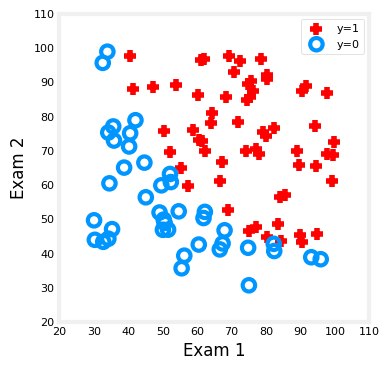

In [11]:
fix, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(X_train, y_train, ax)

# Set both axes
ax.axis([20, 110, 20, 110])
ax.set_ylabel("Exam 2", fontsize=12)
ax.set_xlabel("Exam 1", fontsize=12)

plt.savefig("../imgs/week4_x_y_plots.png")
plt.show()

## Implement the Cost Function

Implement the Cost Function with Gradient Descent and plot the cost with the number of iterations.

In [12]:
def sigmoid(z):
    g = 1.0 / (1.0 + np.exp(-z))
    return g

In [13]:
def compute_gradient_logistic(X, y, w, b): 
    """
    Computes the gradient for linear regression 
 
    Args:
      X (ndarray (m,n): Data, m examples with n features
      y (ndarray (m,)): target values
      w (ndarray (n,)): model parameters  
      b (scalar)      : model parameter
    Returns
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar)      : The gradient of the cost w.r.t. the parameter b. 
    """
    m,n = X.shape
    dj_dw = np.zeros((n,))                           #(n,)
    dj_db = 0.

    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i],w) + b)          #(n,)(n,)=scalar
        err_i  = f_wb_i  - y[i]                       #scalar
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i,j]      #scalar
        dj_db = dj_db + err_i
    dj_dw = dj_dw/m                                   #(n,)
    dj_db = dj_db/m                                   #scalar
        
    return dj_db, dj_dw

In [14]:
def compute_cost_logistic(X, y, w, b, lambda_=0, safe=False):
    """
    Computes cost using logistic loss, non-matrix version

    Args:
      X (ndarray): Shape (m,n)  matrix of examples with n features
      y (ndarray): Shape (m,)   target values
      w (ndarray): Shape (n,)   parameters for prediction
      b (scalar):               parameter  for prediction
      lambda_ : (scalar, float) Controls amount of regularization, 0 = no regularization
      safe : (boolean)          True-selects under/overflow safe algorithm
    Returns:
      cost (scalar): cost
    """

    m,n = X.shape
    cost = 0.0
    for i in range(m):
        z_i    = np.dot(X[i],w) + b                                             #(n,)(n,) or (n,) ()
        if safe:  #avoids overflows
            cost += -(y[i] * z_i ) + log_1pexp(z_i)
        else:
            f_wb_i = sigmoid(z_i)                                                   #(n,)
            cost  += -y[i] * np.log(f_wb_i) - (1 - y[i]) * np.log(1 - f_wb_i)       # scalar
    cost = cost/m

    reg_cost = 0
    if lambda_ != 0:
        for j in range(n):
            reg_cost += (w[j]**2)                                               # scalar
        reg_cost = (lambda_/(2*m))*reg_cost

    return cost + reg_cost

In [15]:
def gradient_descent(X, y, w_in, b_in, alpha, num_iters): 
    """
    Performs batch gradient descent
    
    Args:
      X (ndarray (m,n)   : Data, m examples with n features
      y (ndarray (m,))   : target values
      w_in (ndarray (n,)): Initial values of model parameters  
      b_in (scalar)      : Initial values of model parameter
      alpha (float)      : Learning rate
      num_iters (scalar) : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,))   : Updated values of parameters
      b (scalar)         : Updated value of parameter 
    """
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):
        # Calculate the gradient and update the parameters
        dj_db, dj_dw = compute_gradient_logistic(X, y, w, b)   

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               
        b = b - alpha * dj_db               
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( compute_cost_logistic(X, y, w, b) )

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]}   ")
        
    return w, b, J_history         #return final w,b and J history for graphing


## Final Parameters

In [16]:
w_tmp  = np.zeros_like(X_train[1])
b_tmp  = 1.0
alph = 0.001
iters = 100000

w_out, b_out, J_hist = gradient_descent(X_train, y_train, w_tmp, b_tmp, alph, iters) 
print(f"\nupdated parameters: w:{w_out}, b:{b_out}")

Iteration    0: Cost 0.7117300470590561   
Iteration 10000: Cost 0.6475363679168045   
Iteration 20000: Cost 0.599943335089728   
Iteration 30000: Cost 0.559875786458269   
Iteration 40000: Cost 0.526058704307436   
Iteration 50000: Cost 0.49737825793032875   
Iteration 60000: Cost 0.472900053310536   
Iteration 70000: Cost 0.4518596352108604   
Iteration 80000: Cost 0.43364034316720323   
Iteration 90000: Cost 0.4177479613099146   

updated parameters: w:[0.04 0.03], b:-4.342510163227157


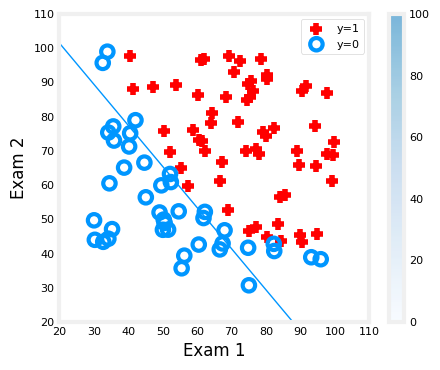

In [17]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
# plot the probability 
plt_prob(ax, w_out, b_out)

# Plot the original data
ax.axis([20, 110, 20, 110])
ax.set_ylabel("Exam 2", fontsize=12)
ax.set_xlabel("Exam 1", fontsize=12)
plot_data(X_train,y_train,ax)

# Plot the decision boundary
x0 = -b_out/w_out[0]
x1 = -b_out/w_out[1]
ax.plot([0,x0],[x1,0], c=dlc["dlblue"], lw=1)

plt.savefig("../imgs/week4_decision_boundary.png")

plt.show()

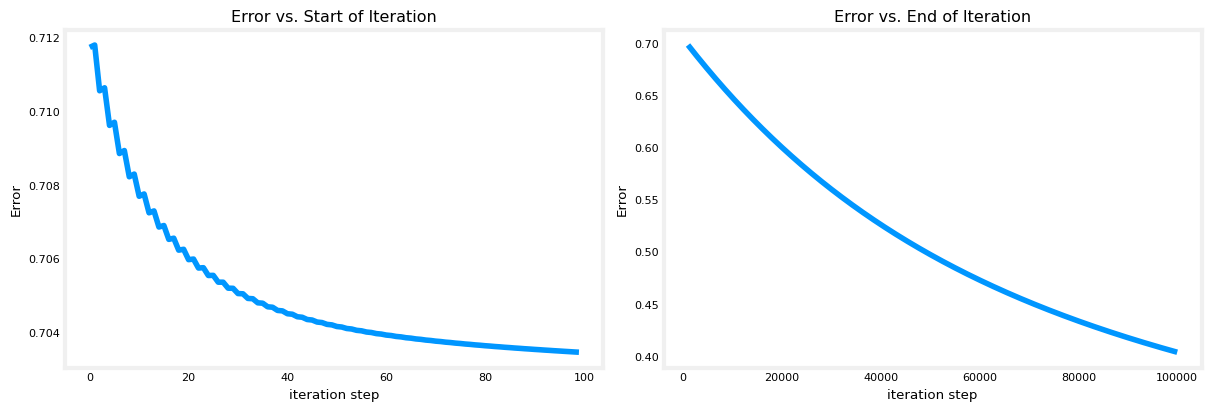

In [18]:
# plot cost versus iteration  
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12,4))
ax1.plot(J_hist[:100])
ax2.plot(1000 + np.arange(len(J_hist[1000:])), J_hist[1000:])
ax1.set_title("Error vs. Start of Iteration");  ax2.set_title("Error vs. End of Iteration")
ax1.set_ylabel('Error')                      ;  ax2.set_ylabel('Error') 
ax1.set_xlabel('iteration step')             ;  ax2.set_xlabel('iteration step') 

plt.savefig("../imgs/week4_error_vs_iteration.png")

plt.show()

## Admission Probability

If a student has an Exam 1 score of 100 and an Exam 2 score of 50, what is the admission probability of this student?

In [26]:
exam1 = 100
exam2 = 50

sigmoid(np.dot(w_out, np.array([exam1, exam2])) + b_out)

0.8250900771569071

### Answer

The probability of a student being admitted, given Exam 1 score of 100 and Exam 2 score of 50 is

$$
P(y=1|\vec{\textbf{x}};\vec{w},b) = 0.82509
$$

or, **82.5%**